In [ ]:
# zk-STARK Simulation: Polynomial Commitment using a Merkle Tree

import hashlib

# --- Utility: Hash function for leaves ---
def hash_leaf(data):
    return hashlib.sha256(data.encode()).hexdigest()

# --- Build a Merkle Tree from a list of leaves ---
def build_merkle_tree(leaves):
    tree = [leaves]
    current_level = leaves
    while len(current_level) > 1:
        next_level = []
        # Duplicate last leaf if current level count is odd
        if len(current_level) % 2 == 1:
            current_level.append(current_level[-1])
        for i in range(0, len(current_level), 2):
            combined = current_level[i] + current_level[i+1]
            next_level.append(hash_leaf(combined))
        tree.append(next_level)
        current_level = next_level
    return tree

def get_merkle_root(tree):
    return tree[-1][0]

def get_merkle_proof(tree, index):
    proof = []
    for level in tree[:-1]:
        # Determine sibling index
        if index % 2 == 0:
            sibling_index = index + 1
        else:
            sibling_index = index - 1
        proof.append(level[sibling_index])
        index //= 2
    return proof

def verify_merkle_proof(leaf, proof, root, index):
    current_hash = hash_leaf(leaf)
    for sibling_hash in proof:
        if index % 2 == 0:
            current_hash = hash_leaf(current_hash + sibling_hash)
        else:
            current_hash = hash_leaf(sibling_hash + current_hash)
        index //= 2
    return current_hash == root

# --- Simulate Polynomial Commitment ---
print("----- zk-STARK Simulation: Polynomial Commitment -----")

# Define a simple polynomial, e.g., f(x) = 2x + 3
def f(x):
    return 2 * x + 3

# Choose a domain (e.g., x values from 0 to 7)
domain = list(range(8))
evaluations = [str(f(x)) for x in domain]
print("Polynomial evaluations:", evaluations)

# Create leaves by hashing each evaluation
leaves = [hash_leaf(val) for val in evaluations]

# Build the Merkle tree from the leaves
tree = build_merkle_tree(leaves)
merkle_root = get_merkle_root(tree)
print("Merkle Root of polynomial commitments:", merkle_root)

# --- Prover: Generate Merkle Proof for a specific evaluation ---
# For example, prove that f(3) is correctly computed.
x_val = 3
eval_val = str(f(x_val))
leaf = eval_val  # data used in the leaf hash
index = domain.index(x_val)  # find index corresponding to x=3
proof = get_merkle_proof(tree, index)
print("\n[Prover] Provides Merkle proof for f(3) =", eval_val)
print("Merkle Proof:", proof)

# --- Verifier: Check the Merkle Proof ---
verified = verify_merkle_proof(leaf, proof, merkle_root, index)
if verified:
    print("[Verifier] zk-STARK Verification Successful: Evaluation is part of the committed polynomial.")
else:
    print("[Verifier] zk-STARK Verification Failed: Proof does not match the Merkle root.")


----- zk-STARK Simulation: Polynomial Commitment -----
Polynomial evaluations: ['3', '5', '7', '9', '11', '13', '15', '17']
Merkle Root of polynomial commitments: 5844ff97e71d9fee7249808e41e5a599f193447e4f9376178019303aded008e9

[Prover] Provides Merkle proof for f(3) = 9
Merkle Proof: ['7902699be42c8a8e46fbbb4501726517e86b22c56a189f7625a6da49081b2451', 'cbbdb532fd7ee84304eabcfb4fb249da232dfe896b993ece77d1b6d4a90ef3a3', '669fab9b8ca4e1c2d4abddd2382421c7a805ade9d5b10267509b6344f9d55034']
[Verifier] zk-STARK Verification Successful: Evaluation is part of the committed polynomial.


In [ ]:
import time, random, hashlib, asyncio

# ----- Shared Helper Functions -----
def hash_leaf(data: str) -> str:
    """Return SHA256 hash of the given data."""
    return hashlib.sha256(data.encode()).hexdigest()

def build_merkle_tree(leaves: list, delay: float = 0) -> list:
    """
    Build a Merkle tree from a list of leaves.
    If delay > 0, sleep for that many seconds between tree levels.
    Returns the tree as a list of levels (level 0: leaves).
    """
    tree = [leaves]
    current_level = leaves.copy()
    while len(current_level) > 1:
        next_level = []
        if len(current_level) % 2 == 1:  # if odd number of nodes, duplicate the last one
            current_level.append(current_level[-1])
        for i in range(0, len(current_level), 2):
            combined = current_level[i] + current_level[i+1]
            next_level.append(hash_leaf(combined))
        tree.append(next_level)
        current_level = next_level
        if delay:
            time.sleep(delay)
    return tree

def get_merkle_root(tree: list) -> str:
    """Return the Merkle root (top-level hash)."""
    return tree[-1][0]

def get_merkle_proof(tree: list, index: int) -> list:
    """Return the Merkle proof (sibling hashes) for a leaf at 'index'."""
    proof = []
    for level in tree[:-1]:
        # If even, sibling is index+1; if odd, sibling is index-1
        sibling_index = index+1 if index % 2 == 0 else index-1
        proof.append(level[sibling_index])
        index //= 2
    return proof

def verify_merkle_proof(leaf: str, proof: list, root: str, index: int) -> bool:
    """Verify a Merkle proof for the given leaf and index."""
    current_hash = hash_leaf(leaf)
    for sibling_hash in proof:
        if index % 2 == 0:
            current_hash = hash_leaf(current_hash + sibling_hash)
        else:
            current_hash = hash_leaf(sibling_hash + current_hash)
        index //= 2
    return current_hash == root

# ----- Setup: Define Polynomial and Domain -----
def f(x):
    """Example polynomial: f(x) = 2x + 3."""
    return 2 * x + 3

domain = list(range(8))           # Domain: x = 0 to 7
evaluations = [str(f(x)) for x in domain]  # Compute f(x) for each x

# Create leaves by hashing each evaluation.
leaves = [hash_leaf(val) for val in evaluations]

print("Shared setup complete.")
print("Domain:", domain)
print("Evaluations:", evaluations)


Shared setup complete.
Domain: [0, 1, 2, 3, 4, 5, 6, 7]
Evaluations: ['3', '5', '7', '9', '11', '13', '15', '17']


In [ ]:
print("=== Technique 1: Synchronous Simulation with time.sleep() ===")

start_time = time.time()

# Step 1: Compute and display evaluations.
print(f"[{time.strftime('%H:%M:%S')}] Computing polynomial evaluations...")
time.sleep(1)
print("Evaluations:", evaluations)

# Step 2: Build the Merkle Tree with a delay per level.
print(f"[{time.strftime('%H:%M:%S')}] Building Merkle Tree...")
tree = build_merkle_tree(leaves, delay=1)
merkle_root = get_merkle_root(tree)
print("Merkle Root:", merkle_root)
time.sleep(1)

# Step 3: Generate a Merkle proof for a specific point (e.g., x = 3).
index = domain.index(3)
leaf_data = evaluations[index]
proof = get_merkle_proof(tree, index)
print(f"[{time.strftime('%H:%M:%S')}] Generating Merkle Proof for f(3) = {leaf_data}")
print("Proof:", proof)
time.sleep(1)

# Step 4: Verify the proof.
verified = verify_merkle_proof(leaf_data, proof, merkle_root, index)
print(f"[{time.strftime('%H:%M:%S')}] Verification {'Successful' if verified else 'Failed'}.")

end_time = time.time()
print(f"Technique 1 completed in {end_time - start_time:.4f} seconds.\n")


=== Technique 1: Synchronous Simulation with time.sleep() ===
[13:47:54] Computing polynomial evaluations...
Evaluations: ['3', '5', '7', '9', '11', '13', '15', '17']
[13:47:55] Building Merkle Tree...
Merkle Root: 5844ff97e71d9fee7249808e41e5a599f193447e4f9376178019303aded008e9
[13:47:59] Generating Merkle Proof for f(3) = 9
Proof: ['7902699be42c8a8e46fbbb4501726517e86b22c56a189f7625a6da49081b2451', 'cbbdb532fd7ee84304eabcfb4fb249da232dfe896b993ece77d1b6d4a90ef3a3', '669fab9b8ca4e1c2d4abddd2382421c7a805ade9d5b10267509b6344f9d55034']
[13:48:00] Verification Successful.
Technique 1 completed in 6.0036 seconds.



In [ ]:
print("=== Technique 2: Interactive Simulation with User Input ===")

input("Press Enter to compute polynomial evaluations...")
print("Evaluations:", evaluations)

input("Press Enter to build the Merkle Tree...")
tree = build_merkle_tree(leaves, delay=0)  # No delay; waiting on user input instead.
merkle_root = get_merkle_root(tree)
print("Merkle Root:", merkle_root)

input("Press Enter to generate the Merkle Proof for f(3)...")
index = domain.index(3)
leaf_data = evaluations[index]
proof = get_merkle_proof(tree, index)
print(f"Merkle Proof for f(3) = {leaf_data}:")
print("Proof:", proof)

input("Press Enter to verify the proof...")
verified = verify_merkle_proof(leaf_data, proof, merkle_root, index)
print("Verification", "Successful" if verified else "Failed", "\n")


=== Technique 2: Interactive Simulation with User Input ===
Press Enter to compute polynomial evaluations...
Evaluations: ['3', '5', '7', '9', '11', '13', '15', '17']
Press Enter to build the Merkle Tree...
Merkle Root: 5844ff97e71d9fee7249808e41e5a599f193447e4f9376178019303aded008e9
Press Enter to generate the Merkle Proof for f(3)...
Merkle Proof for f(3) = 9:
Proof: ['7902699be42c8a8e46fbbb4501726517e86b22c56a189f7625a6da49081b2451', 'cbbdb532fd7ee84304eabcfb4fb249da232dfe896b993ece77d1b6d4a90ef3a3', '669fab9b8ca4e1c2d4abddd2382421c7a805ade9d5b10267509b6344f9d55034']
Press Enter to verify the proof...
Verification Successful 



In [ ]:
print("=== Technique 3: Asynchronous Simulation with asyncio ===")

async def async_zkstark_simulation(delay: float = 0.5):
    start = time.time()

    print(f"[{time.strftime('%H:%M:%S')}] Asynchronously computing polynomial evaluations...")
    await asyncio.sleep(delay)
    print("Evaluations:", evaluations)

    print(f"[{time.strftime('%H:%M:%S')}] Asynchronously building Merkle Tree...")
    tree = await async_build_merkle_tree(leaves, delay=delay)
    merkle_root = get_merkle_root(tree)
    print("Merkle Root:", merkle_root)
    await asyncio.sleep(delay)

    index = domain.index(3)
    leaf_data = evaluations[index]
    proof = get_merkle_proof(tree, index)
    print(f"[{time.strftime('%H:%M:%S')}] Asynchronously generating Merkle Proof for f(3) = {leaf_data}")
    print("Proof:", proof)
    await asyncio.sleep(delay)

    verified = verify_merkle_proof(leaf_data, proof, merkle_root, index)
    print(f"[{time.strftime('%H:%M:%S')}] Asynchronous Verification {'Successful' if verified else 'Failed'}.")

    end = time.time()
    print(f"Technique 3 completed in {end - start:.4f} seconds.\n")
    return verified

async def async_build_merkle_tree(leaves: list, delay: float = 0.5) -> list:
    tree = [leaves]
    current_level = leaves.copy()
    while len(current_level) > 1:
        next_level = []
        if len(current_level) % 2 == 1:
            current_level.append(current_level[-1])
        for i in range(0, len(current_level), 2):
            combined = current_level[i] + current_level[i+1]
            next_level.append(hash_leaf(combined))
        tree.append(next_level)
        current_level = next_level
        await asyncio.sleep(delay)  # asynchronous delay between levels
    return tree

# Run the asynchronous simulation.
await async_zkstark_simulation(delay=0.5)


=== Technique 3: Asynchronous Simulation with asyncio ===
[13:49:46] Asynchronously computing polynomial evaluations...
Evaluations: ['3', '5', '7', '9', '11', '13', '15', '17']
[13:49:47] Asynchronously building Merkle Tree...
Merkle Root: 5844ff97e71d9fee7249808e41e5a599f193447e4f9376178019303aded008e9
[13:49:49] Asynchronously generating Merkle Proof for f(3) = 9
Proof: ['7902699be42c8a8e46fbbb4501726517e86b22c56a189f7625a6da49081b2451', 'cbbdb532fd7ee84304eabcfb4fb249da232dfe896b993ece77d1b6d4a90ef3a3', '669fab9b8ca4e1c2d4abddd2382421c7a805ade9d5b10267509b6344f9d55034']
[13:49:49] Asynchronous Verification Successful.
Technique 3 completed in 3.0049 seconds.



True

In [ ]:
import time, random, hashlib, asyncio

# =============================================================================
# Assume Shared Setup and Helper Functions from Step 0 are already defined.
# If not, please run the "Step 0: Shared Functions and Setup" cell first.
# =============================================================================

# -----------------------------------------------------------------------------
# Technique 1: Synchronous Simulation with time.sleep()
# -----------------------------------------------------------------------------
def technique1_sync(delay: float = 1.0):
    start = time.time()
    # Step 1: Compute and display evaluations.
    print(f"[{time.strftime('%H:%M:%S')}] (Sync) Computing polynomial evaluations...")
    time.sleep(delay)
    print("Evaluations:", evaluations)

    # Step 2: Build the Merkle Tree with a delay per level.
    print(f"[{time.strftime('%H:%M:%S')}] (Sync) Building Merkle Tree...")
    tree = build_merkle_tree(leaves, delay=delay)
    merkle_root = get_merkle_root(tree)
    print("Merkle Root:", merkle_root)
    time.sleep(delay)

    # Step 3: Generate Merkle Proof for f(3)
    index = domain.index(3)
    leaf_data = evaluations[index]
    proof = get_merkle_proof(tree, index)
    print(f"[{time.strftime('%H:%M:%S')}] (Sync) Generated Merkle Proof for f(3) = {leaf_data}")
    print("Proof:", proof)
    time.sleep(delay)

    # Step 4: Verify the proof.
    verified = verify_merkle_proof(leaf_data, proof, merkle_root, index)
    print(f"[{time.strftime('%H:%M:%S')}] (Sync) Verification {'Successful' if verified else 'Failed'}.\n")

    return verified, time.time() - start

# -----------------------------------------------------------------------------
# Technique 2: Interactive Simulation with Simulated User Input
# (We replace input() with fixed delays for automatic timing)
# -----------------------------------------------------------------------------
def technique2_interactive_simulated():
    start = time.time()

    time.sleep(1)  # Simulate waiting for user input to compute evaluations
    print("[Interactive] Evaluations:", evaluations)

    time.sleep(1)  # Simulate waiting for user input to build the tree
    tree = build_merkle_tree(leaves, delay=0)
    merkle_root = get_merkle_root(tree)
    print("[Interactive] Merkle Root:", merkle_root)

    time.sleep(1)  # Simulate waiting for user input to generate the proof
    index = domain.index(3)
    leaf_data = evaluations[index]
    proof = get_merkle_proof(tree, index)
    print(f"[Interactive] Merkle Proof for f(3) = {leaf_data}:")
    print("Proof:", proof)

    time.sleep(1)  # Simulate waiting for user input to verify the proof
    verified = verify_merkle_proof(leaf_data, proof, merkle_root, index)
    print("[Interactive] Verification", "Successful" if verified else "Failed", "\n")

    return verified, time.time() - start

# -----------------------------------------------------------------------------
# Technique 3: Asynchronous Simulation with asyncio
# -----------------------------------------------------------------------------
async def async_build_merkle_tree(leaves: list, delay: float = 0.5) -> list:
    tree = [leaves]
    current_level = leaves.copy()
    while len(current_level) > 1:
        next_level = []
        if len(current_level) % 2 == 1:
            current_level.append(current_level[-1])
        for i in range(0, len(current_level), 2):
            combined = current_level[i] + current_level[i+1]
            next_level.append(hash_leaf(combined))
        tree.append(next_level)
        current_level = next_level
        await asyncio.sleep(delay)
    return tree

async def async_zkstark_simulation(delay: float = 0.5):
    start = time.time()
    print(f"[{time.strftime('%H:%M:%S')}] (Async) Asynchronously computing polynomial evaluations...")
    await asyncio.sleep(delay)
    print("Evaluations:", evaluations)

    print(f"[{time.strftime('%H:%M:%S')}] (Async) Asynchronously building Merkle Tree...")
    tree = await async_build_merkle_tree(leaves, delay=delay)
    merkle_root = get_merkle_root(tree)
    print("Merkle Root:", merkle_root)
    await asyncio.sleep(delay)

    index = domain.index(3)
    leaf_data = evaluations[index]
    proof = get_merkle_proof(tree, index)
    print(f"[{time.strftime('%H:%M:%S')}] (Async) Asynchronously generating Merkle Proof for f(3) = {leaf_data}")
    print("Proof:", proof)
    await asyncio.sleep(delay)

    verified = verify_merkle_proof(leaf_data, proof, merkle_root, index)
    print(f"[{time.strftime('%H:%M:%S')}] (Async) Verification {'Successful' if verified else 'Failed'}.\n")

    return verified, time.time() - start

# -----------------------------------------------------------------------------
# Comparative Simulation Runner for zk-STARK Techniques
# -----------------------------------------------------------------------------
num_rounds = 3

sync_times = []
for i in range(num_rounds):
    print(f"--- Technique 1: Synchronous Round {i+1} ---")
    _, t = technique1_sync(delay=1)
    sync_times.append(t)

interact_times = []
for i in range(num_rounds):
    print(f"--- Technique 2: Interactive Simulated Round {i+1} ---")
    _, t = technique2_interactive_simulated()
    interact_times.append(t)

async_times = []
async def run_async_rounds():
    results = []
    for i in range(num_rounds):
        print(f"--- Technique 3: Asynchronous Round {i+1} ---")
        valid, t = await async_zkstark_simulation(delay=0.5)
        results.append(t)
    return results

async_results = await run_async_rounds()
async_times.extend(async_results)

# -----------------------------------------------------------------------------
# Compute Average Times
# -----------------------------------------------------------------------------
avg_sync = sum(sync_times) / num_rounds
avg_interact = sum(interact_times) / num_rounds
avg_async = sum(async_times) / num_rounds

# -----------------------------------------------------------------------------
# Print Comparative Analysis Table
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("Comparative Analysis of zk-STARK Simulation Techniques (over {} rounds):".format(num_rounds))
print("="*80)
print(f"Synchronous Simulation (time.sleep):        Avg Time = {avg_sync:.4f} seconds")
print(f"Interactive Simulation (simulated input):    Avg Time = {avg_interact:.4f} seconds")
print(f"Asynchronous Simulation (asyncio):           Avg Time = {avg_async:.4f} seconds")
print("="*80 + "\n")

# -----------------------------------------------------------------------------
# Detailed Comparative Table (Text Format)
# -----------------------------------------------------------------------------
print("+------------------------------+----------------------------+---------------------------------------------------------+")
print("| Technique                    | Avg Time per Round (s)     | Characteristics                                         |")
print("+------------------------------+----------------------------+---------------------------------------------------------+")
print(f"| Synchronous Simulation       | {avg_sync:24.4f} | Sequential & blocking; simple fixed delays.             |")
print(f"| Interactive (Simulated)      | {avg_interact:24.4f} | Mimics manual control with simulated input delays.       |")
print(f"| Asynchronous Simulation      | {avg_async:24.4f} | Concurrent, non-blocking; efficient task scheduling.     |")
print("+------------------------------+----------------------------+---------------------------------------------------------+")


--- Technique 1: Synchronous Round 1 ---
[13:53:33] (Sync) Computing polynomial evaluations...
Evaluations: ['3', '5', '7', '9', '11', '13', '15', '17']
[13:53:34] (Sync) Building Merkle Tree...
Merkle Root: 5844ff97e71d9fee7249808e41e5a599f193447e4f9376178019303aded008e9
[13:53:38] (Sync) Generated Merkle Proof for f(3) = 9
Proof: ['7902699be42c8a8e46fbbb4501726517e86b22c56a189f7625a6da49081b2451', 'cbbdb532fd7ee84304eabcfb4fb249da232dfe896b993ece77d1b6d4a90ef3a3', '669fab9b8ca4e1c2d4abddd2382421c7a805ade9d5b10267509b6344f9d55034']
[13:53:39] (Sync) Verification Successful.

--- Technique 1: Synchronous Round 2 ---
[13:53:39] (Sync) Computing polynomial evaluations...
Evaluations: ['3', '5', '7', '9', '11', '13', '15', '17']
[13:53:40] (Sync) Building Merkle Tree...
Merkle Root: 5844ff97e71d9fee7249808e41e5a599f193447e4f9376178019303aded008e9
[13:53:44] (Sync) Generated Merkle Proof for f(3) = 9
Proof: ['7902699be42c8a8e46fbbb4501726517e86b22c56a189f7625a6da49081b2451', 'cbbdb532fd7ee

In [ ]:
import asyncio, time, random, json, hashlib, statistics

# ------------------------------
# Shared Helper Functions
# ------------------------------

def current_time():
    return time.strftime('%H:%M:%S')

def hash_leaf(data: str) -> str:
    """Return the SHA256 hash of the given string data."""
    return hashlib.sha256(data.encode()).hexdigest()

def build_merkle_tree(leaves: list, delay: float = 0) -> list:
    """
    Build a Merkle tree from a list of leaves.
    Returns the tree as a list of levels (level 0: leaves).
    Optionally delays between levels to simulate processing time.
    """
    tree = [leaves]
    current_level = leaves.copy()
    while len(current_level) > 1:
        next_level = []
        if len(current_level) % 2 == 1:
            current_level.append(current_level[-1])
        for i in range(0, len(current_level), 2):
            combined = current_level[i] + current_level[i+1]
            next_level.append(hash_leaf(combined))
        tree.append(next_level)
        current_level = next_level
        if delay:
            time.sleep(delay)
    return tree

def get_merkle_root(tree: list) -> str:
    """Return the Merkle root (the sole hash in the final level)."""
    return tree[-1][0]

def get_merkle_proof(tree: list, index: int) -> list:
    """Return the Merkle proof (list of sibling hashes) for a leaf at the given index."""
    proof = []
    for level in tree[:-1]:
        sibling_index = index+1 if index % 2 == 0 else index-1
        proof.append(level[sibling_index])
        index //= 2
    return proof

def verify_merkle_proof(leaf: str, proof: list, root: str, index: int) -> bool:
    """Verify the Merkle proof for the given leaf and index."""
    current_hash = hash_leaf(leaf)
    for sibling_hash in proof:
        if index % 2 == 0:
            current_hash = hash_leaf(current_hash + sibling_hash)
        else:
            current_hash = hash_leaf(sibling_hash + current_hash)
        index //= 2
    return current_hash == root

# ------------------------------
# Setup for zk-STARK Simulation
# ------------------------------

# Define a simple polynomial: f(x) = 2x + 3
def f(x):
    return 2 * x + 3

domain = list(range(8))  # Domain: x=0,...,7
# Compute evaluations as strings
evaluations = [str(f(x)) for x in domain]
# Create leaves by hashing each evaluation
leaves = [hash_leaf(val) for val in evaluations]

# ------------------------------
# Verifier Server (zk-STARK Verifier)
# ------------------------------

async def stark_verifier(reader: asyncio.StreamReader, writer: asyncio.StreamWriter):
    peer = writer.get_extra_info('peername')
    print(f"[{current_time()}] [Verifier] Connection accepted from {peer}")

    # Read the incoming JSON message (ending with a newline)
    data = await reader.readline()
    if not data:
        writer.close()
        return
    try:
        message = json.loads(data.decode().strip())
    except Exception as e:
        print(f"[{current_time()}] [Verifier] Error decoding message: {e}")
        writer.close()
        return

    # Extract fields: merkle_root, index, evaluation, proof
    merkle_root = message.get("merkle_root")
    index = message.get("index")
    evaluation = message.get("evaluation")
    proof = message.get("proof")

    print(f"[{current_time()}] [Verifier] Received Merkle Root: {merkle_root}")
    print(f"[{current_time()}] [Verifier] Received evaluation for index {index}: {evaluation}")
    print(f"[{current_time()}] [Verifier] Received Merkle Proof: {proof}")
    await asyncio.sleep(2)  # simulate network delay

    # Verify the proof: The leaf is the hash of the evaluation string.
    leaf = evaluation  # In our simulation, we assume the leaf is computed as hash_leaf(evaluation)
    valid = verify_merkle_proof(leaf, proof, merkle_root, index)
    print(f"[{current_time()}] [Verifier] Verification {'Successful' if valid else 'Failed'}")
    await asyncio.sleep(2)

    # Send back the result as JSON (just a simple OK/FAIL message)
    response = {"result": "OK" if valid else "FAIL"}
    writer.write((json.dumps(response) + "\n").encode())
    await writer.drain()

    print(f"[{current_time()}] [Verifier] Closing connection.\n")
    writer.close()
    await writer.wait_closed()

# ------------------------------
# Prover Client (zk-STARK Prover)
# ------------------------------

async def stark_prover(round_num: int, delay_between_rounds: float = 1.0, network_delay: float = 2.0):
    round_start = time.time()

    # The prover builds the Merkle tree (simulate processing delay)
    print(f"[{current_time()}] [Prover] (Round {round_num}) Building Merkle tree for polynomial evaluations...")
    tree = build_merkle_tree(leaves, delay=network_delay/2)  # delay per level
    merkle_root = get_merkle_root(tree)
    await asyncio.sleep(network_delay)  # simulate delay after building tree

    # Choose an index for which to prove the evaluation.
    # For demonstration, we can choose a fixed index (say, index 3)
    index = 3
    evaluation = evaluations[index]
    proof = get_merkle_proof(tree, index)

    print(f"[{current_time()}] [Prover] (Round {round_num}) Prepared commitment (Merkle Root): {merkle_root}")
    print(f"[{current_time()}] [Prover] (Round {round_num}) Evaluation for index {index}: {evaluation}")
    print(f"[{current_time()}] [Prover] (Round {round_num}) Merkle Proof: {proof}")
    await asyncio.sleep(network_delay)

    # Prepare the message (as a JSON object)
    message = {
        "merkle_root": merkle_root,
        "index": index,
        "evaluation": evaluation,
        "proof": proof
    }

    # Connect to the verifier server and send the message.
    reader, writer = await asyncio.open_connection('127.0.0.1', 8889)
    print(f"[{current_time()}] [Prover] (Round {round_num}) Connected to verifier.")
    writer.write((json.dumps(message) + "\n").encode())
    await writer.drain()
    await asyncio.sleep(network_delay)

    # Read the verifier's response.
    data = await reader.readline()
    response = json.loads(data.decode().strip())
    result = response.get("result", "FAIL")
    print(f"[{current_time()}] [Prover] (Round {round_num}) Received verification result: {result}")

    writer.close()
    await writer.wait_closed()

    round_duration = time.time() - round_start
    print(f"[{current_time()}] [Prover] (Round {round_num}) Completed in {round_duration:.2f} seconds.\n")
    await asyncio.sleep(delay_between_rounds)
    return round_duration, result

# ------------------------------
# Main Routine: Run Multiple Rounds for zk-STARK Simulation
# ------------------------------

async def run_multiple_rounds_stark(num_rounds: int = 10):
    # Start the verifier server on localhost:8889
    server = await asyncio.start_server(stark_verifier, '127.0.0.1', 8889)
    addr = server.sockets[0].getsockname()
    print(f"[{current_time()}] [Main] zk-STARK Verifier Server started on {addr}\n")

    # Run the server forever (in a background task)
    server_task = asyncio.create_task(server.serve_forever())

    # Run multiple rounds of the prover simulation.
    round_times = []
    results = []
    for i in range(1, num_rounds + 1):
        print(f"================ Round {i} =================")
        r_time, result = await stark_prover(round_num=i, delay_between_rounds=1.0, network_delay=2.0)
        round_times.append(r_time)
        results.append(result)

    # Cancel the server once rounds are complete.
    server_task.cancel()
    try:
        await server_task
    except asyncio.CancelledError:
        print(f"[{current_time()}] [Main] Verifier Server task cancelled.")

    # Compute statistics.
    avg_time = sum(round_times) / len(round_times)
    median_time = statistics.median(round_times)
    min_time = min(round_times)
    max_time = max(round_times)
    std_dev = statistics.stdev(round_times) if len(round_times) > 1 else 0

    print("\n" + "="*80)
    print("Comparative Metrics for zk-STARK Simulation (Merkle Commitment):")
    print("="*80)
    print(f"Number of Rounds       : {num_rounds}")
    print(f"Total Simulation Time  : {sum(round_times):.2f} seconds")
    print(f"Average Round Time     : {avg_time:.2f} seconds")
    print(f"Median Round Time      : {median_time:.2f} seconds")
    print(f"Minimum Round Time     : {min_time:.2f} seconds")
    print(f"Maximum Round Time     : {max_time:.2f} seconds")
    print(f"Standard Deviation     : {std_dev:.2f} seconds")
    print(f"Verification Results   : {results}")
    print("="*80 + "\n")

    return round_times

# ------------------------------
# Run the zk-STARK Simulation
# ------------------------------

start_sim = time.time()
await run_multiple_rounds_stark(num_rounds=10)
end_sim = time.time()
print(f"Total simulation time: {end_sim - start_sim:.2f} seconds")


[14:18:34] [Main] zk-STARK Verifier Server started on ('127.0.0.1', 8889)

================ Round 1 =================
[14:18:34] [Prover] (Round 1) Building Merkle tree for polynomial evaluations...
[14:18:39] [Prover] (Round 1) Prepared commitment (Merkle Root): 5844ff97e71d9fee7249808e41e5a599f193447e4f9376178019303aded008e9
[14:18:39] [Prover] (Round 1) Evaluation for index 3: 9
[14:18:39] [Prover] (Round 1) Merkle Proof: ['7902699be42c8a8e46fbbb4501726517e86b22c56a189f7625a6da49081b2451', 'cbbdb532fd7ee84304eabcfb4fb249da232dfe896b993ece77d1b6d4a90ef3a3', '669fab9b8ca4e1c2d4abddd2382421c7a805ade9d5b10267509b6344f9d55034']
[14:18:41] [Verifier] Connection accepted from ('127.0.0.1', 51744)
[14:18:41] [Prover] (Round 1) Connected to verifier.
[14:18:41] [Verifier] Received Merkle Root: 5844ff97e71d9fee7249808e41e5a599f193447e4f9376178019303aded008e9
[14:18:41] [Verifier] Received evaluation for index 3: 9
[14:18:41] [Verifier] Received Merkle Proof: ['7902699be42c8a8e46fbbb4501726517

========== Running Simulation: Used Technique (SHA-256) ==========

[14:28:39] [Main] zk-STARK Verifier Server using used_hash started on ('127.0.0.1', 8890)

================ Round 1 =================
[14:28:39] [Prover] (Round 1) Building Merkle tree using used_hash ...
[14:28:44] [Prover] (Round 1) Commitment (Merkle Root): 5844ff97e71d9fee7249808e41e5a599f193447e4f9376178019303aded008e9
[14:28:44] [Prover] (Round 1) Evaluation at index 3: 9
[14:28:44] [Prover] (Round 1) Merkle Proof: ['7902699be42c8a8e46fbbb4501726517e86b22c56a189f7625a6da49081b2451', 'cbbdb532fd7ee84304eabcfb4fb249da232dfe896b993ece77d1b6d4a90ef3a3', '669fab9b8ca4e1c2d4abddd2382421c7a805ade9d5b10267509b6344f9d55034']
[14:28:46] [Verifier] Connection accepted from ('127.0.0.1', 35486)
[14:28:46] [Prover] (Round 1) Connected to verifier on port 8890.
[14:28:46] [Verifier] Received Merkle Root: 5844ff97e71d9fee7249808e41e5a599f193447e4f9376178019303aded008e9
[14:28:46] [Verifier] Received evaluation at index 3: 9
[14

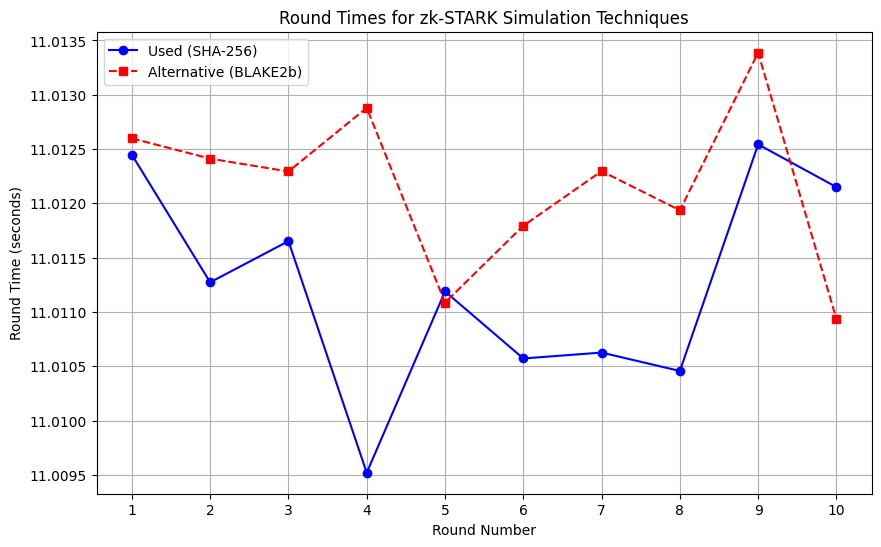

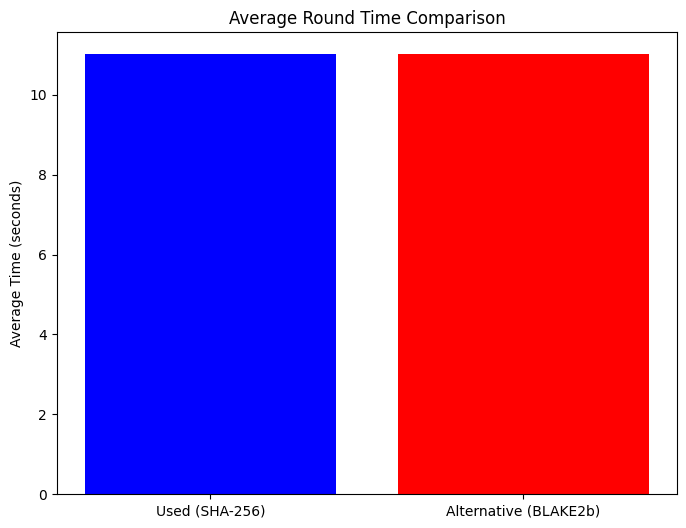

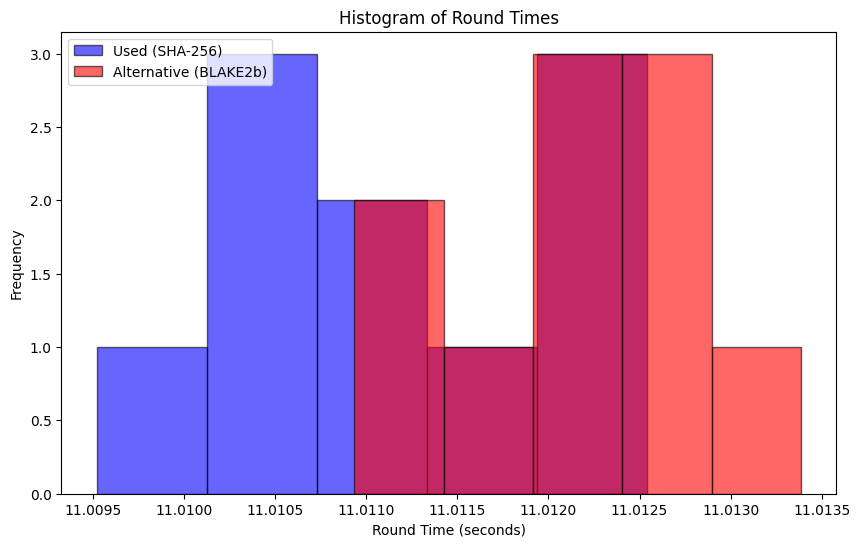

Total simulation time for both techniques: 240.95 seconds


In [ ]:
import asyncio, time, random, json, hashlib, statistics
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Set a fixed random seed for reproducibility
random.seed(42)

# ----------------------------
# Define Two Hash Functions
# ----------------------------

def used_hash(data: str) -> str:
    """Used technique: SHA-256 hash."""
    return hashlib.sha256(data.encode()).hexdigest()

def alternative_hash(data: str) -> str:
    """Alternative technique: BLAKE2b hash with 32-byte digest."""
    return hashlib.blake2b(data.encode(), digest_size=32).hexdigest()

# ----------------------------
# Merkle Tree Functions (Parameterized by hash function)
# ----------------------------

def build_merkle_tree(hash_func, leaves: list, delay: float = 0) -> list:
    """
    Build a Merkle tree from a list of leaves using the provided hash_func.
    Returns the tree as a list of levels (level 0: leaves).
    If delay > 0, sleeps between levels (using time.sleep).
    """
    tree = [leaves]
    current_level = leaves.copy()
    while len(current_level) > 1:
        next_level = []
        if len(current_level) % 2 == 1:
            current_level.append(current_level[-1])
        for i in range(0, len(current_level), 2):
            combined = current_level[i] + current_level[i+1]
            next_level.append(hash_func(combined))
        tree.append(next_level)
        current_level = next_level
        if delay:
            time.sleep(delay)
    return tree

def get_merkle_root(tree: list) -> str:
    """Return the Merkle root (the sole element in the last level)."""
    return tree[-1][0]

def get_merkle_proof(tree: list, index: int) -> list:
    """Return the Merkle proof (list of sibling hashes) for the leaf at the given index."""
    proof = []
    for level in tree[:-1]:
        sibling_index = index + 1 if index % 2 == 0 else index - 1
        proof.append(level[sibling_index])
        index //= 2
    return proof

def verify_merkle_proof(hash_func, leaf: str, proof: list, root: str, index: int) -> bool:
    """Verify the Merkle proof for a given leaf and index using the provided hash_func."""
    current_hash = hash_func(leaf)
    for sibling_hash in proof:
        if index % 2 == 0:
            current_hash = hash_func(current_hash + sibling_hash)
        else:
            current_hash = hash_func(sibling_hash + current_hash)
        index //= 2
    return current_hash == root

# ----------------------------
# Polynomial & Setup
# ----------------------------

def f(x):
    """Define a simple polynomial: f(x)=2x+3."""
    return 2 * x + 3

domain = list(range(8))  # x = 0,...,7
# Evaluations will be computed as strings.
evaluations = [str(f(x)) for x in domain]
# (For each simulation, leaves are computed as: hash_func(evaluation) for each evaluation.)

# ----------------------------
# Utility for Timestamped Logging
# ----------------------------

def current_time():
    return time.strftime('%H:%M:%S')

# ----------------------------
# zk-STARK Verifier Server (Parameterized by hash function)
# ----------------------------

async def stark_verifier(hash_func, reader: asyncio.StreamReader, writer: asyncio.StreamWriter):
    peer = writer.get_extra_info('peername')
    print(f"[{current_time()}] [Verifier] Connection accepted from {peer}")

    # Read one JSON message (ending with newline)
    data = await reader.readline()
    if not data:
        writer.close()
        return
    try:
        message = json.loads(data.decode().strip())
    except Exception as e:
        print(f"[{current_time()}] [Verifier] JSON decode error: {e}")
        writer.close()
        return

    # Expected fields: merkle_root, index, evaluation, proof.
    merkle_root = message.get("merkle_root")
    index = message.get("index")
    evaluation = message.get("evaluation")
    proof = message.get("proof")

    print(f"[{current_time()}] [Verifier] Received Merkle Root: {merkle_root}")
    print(f"[{current_time()}] [Verifier] Received evaluation at index {index}: {evaluation}")
    print(f"[{current_time()}] [Verifier] Received Merkle Proof: {proof}")
    await asyncio.sleep(2)  # simulate network delay

    # In our simulation, we assume the "leaf" is the hash of the evaluation.
    # (This is our commitment; in a real implementation, it might be computed differently.)
    leaf = evaluation
    valid = verify_merkle_proof(hash_func, leaf, proof, merkle_root, index)
    print(f"[{current_time()}] [Verifier] Verification {'Successful' if valid else 'Failed'}")
    await asyncio.sleep(2)

    # Send back verification result as JSON.
    response = {"result": "OK" if valid else "FAIL"}
    writer.write((json.dumps(response) + "\n").encode())
    await writer.drain()

    print(f"[{current_time()}] [Verifier] Closing connection.\n")
    writer.close()
    await writer.wait_closed()

# ----------------------------
# zk-STARK Prover Client (Parameterized by hash function)
# ----------------------------

async def stark_prover(hash_func, round_num: int, port: int, net_delay: float = 2.0):
    round_start = time.time()

    # Build Merkle tree from evaluations (each leaf is computed as hash_func(evaluation))
    leaves = [hash_func(val) for val in evaluations]
    print(f"[{current_time()}] [Prover] (Round {round_num}) Building Merkle tree using {hash_func.__name__} ...")
    # Use a fixed delay per level to simulate processing time.
    tree = build_merkle_tree(hash_func, leaves, delay=net_delay/2)
    merkle_root = get_merkle_root(tree)
    await asyncio.sleep(net_delay)

    # For demonstration, choose a fixed index (say, index 3).
    index = 3
    evaluation = evaluations[index]
    proof = get_merkle_proof(tree, index)

    print(f"[{current_time()}] [Prover] (Round {round_num}) Commitment (Merkle Root): {merkle_root}")
    print(f"[{current_time()}] [Prover] (Round {round_num}) Evaluation at index {index}: {evaluation}")
    print(f"[{current_time()}] [Prover] (Round {round_num}) Merkle Proof: {proof}")
    await asyncio.sleep(net_delay)

    # Prepare JSON message.
    message = {
        "merkle_root": merkle_root,
        "index": index,
        "evaluation": evaluation,
        "proof": proof
    }

    # Connect to the verifier server.
    reader, writer = await asyncio.open_connection('127.0.0.1', port)
    print(f"[{current_time()}] [Prover] (Round {round_num}) Connected to verifier on port {port}.")
    writer.write((json.dumps(message) + "\n").encode())
    await writer.drain()
    await asyncio.sleep(net_delay)

    # Read verifier's response.
    data = await reader.readline()
    response = json.loads(data.decode().strip())
    result = response.get("result", "FAIL")
    print(f"[{current_time()}] [Prover] (Round {round_num}) Received verification result: {result}")

    writer.close()
    await writer.wait_closed()

    round_duration = time.time() - round_start
    print(f"[{current_time()}] [Prover] (Round {round_num}) Completed in {round_duration:.2f} seconds.\n")
    await asyncio.sleep(1)  # Delay between rounds
    return round_duration, result

# ----------------------------
# Run Multiple Rounds for a Given Technique
# ----------------------------

async def run_multiple_rounds_stark(hash_func, port: int, num_rounds: int = 10, net_delay: float = 2.0):
    # Start the verifier server on the given port.
    server = await asyncio.start_server(lambda r, w: stark_verifier(hash_func, r, w), '127.0.0.1', port)
    addr = server.sockets[0].getsockname()
    print(f"[{current_time()}] [Main] zk-STARK Verifier Server using {hash_func.__name__} started on {addr}\n")

    # Run server in background.
    server_task = asyncio.create_task(server.serve_forever())

    round_times = []
    results = []
    for i in range(1, num_rounds+1):
        print(f"================ Round {i} =================")
        r_time, result = await stark_prover(hash_func, round_num=i, port=port, net_delay=net_delay)
        round_times.append(r_time)
        results.append(result)

    # Shutdown the server.
    server_task.cancel()
    try:
        await server_task
    except asyncio.CancelledError:
        print(f"[{current_time()}] [Main] Verifier Server using {hash_func.__name__} task cancelled.\n")

    return round_times, results

# ----------------------------
# Main Routine: Run Both Techniques and Compare
# ----------------------------

async def main_comparison():
    num_rounds = 10
    # Ports for the two simulations.
    port_used = 8890
    port_alternative = 8891

    print("========== Running Simulation: Used Technique (SHA-256) ==========\n")
    times_used, results_used = await run_multiple_rounds_stark(used_hash, port_used, num_rounds, net_delay=2.0)

    print("========== Running Simulation: Alternative Technique (BLAKE2b) ==========\n")
    times_alternative, results_alternative = await run_multiple_rounds_stark(alternative_hash, port_alternative, num_rounds, net_delay=2.0)

    # Compute statistics.
    stats = {}
    for label, times in [("Used (SHA-256)", times_used), ("Alternative (BLAKE2b)", times_alternative)]:
        total = sum(times)
        avg = total / len(times)
        median = statistics.median(times)
        min_time = min(times)
        max_time = max(times)
        std_dev = statistics.stdev(times) if len(times) > 1 else 0
        stats[label] = {
            "Total": total,
            "Average": avg,
            "Median": median,
            "Min": min_time,
            "Max": max_time,
            "StdDev": std_dev,
            "Rounds": len(times)
        }

    # Print comparative table.
    print("\n" + "="*80)
    print("Comparative Metrics for zk-STARK Simulation Techniques:")
    print("="*80)
    print(f"{'Technique':<30} {'Rounds':<7} {'Total (s)':<10} {'Avg (s)':<10} {'Median (s)':<12} {'Min (s)':<8} {'Max (s)':<8} {'StdDev (s)':<10}")
    print("-"*80)
    for label, s in stats.items():
        print(f"{label:<30} {s['Rounds']:<7} {s['Total']:<10.2f} {s['Average']:<10.2f} {s['Median']:<12.2f} {s['Min']:<8.2f} {s['Max']:<8.2f} {s['StdDev']:<10.2f}")
    print("="*80 + "\n")

    # Plot comparative graphs.
    rounds = np.arange(1, num_rounds+1)

    # Line Plot
    plt.figure(figsize=(10, 6))
    plt.plot(rounds, times_used, marker='o', linestyle='-', color='blue', label='Used (SHA-256)')
    plt.plot(rounds, times_alternative, marker='s', linestyle='--', color='red', label='Alternative (BLAKE2b)')
    plt.title("Round Times for zk-STARK Simulation Techniques")
    plt.xlabel("Round Number")
    plt.ylabel("Round Time (seconds)")
    plt.xticks(rounds)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Bar Chart (Average Times)
    techniques = ["Used (SHA-256)", "Alternative (BLAKE2b)"]
    avg_times = [stats["Used (SHA-256)"]["Average"], stats["Alternative (BLAKE2b)"]["Average"]]

    plt.figure(figsize=(8, 6))
    plt.bar(techniques, avg_times, color=['blue', 'red'])
    plt.title("Average Round Time Comparison")
    plt.ylabel("Average Time (seconds)")
    plt.show()

    # Histogram of Round Times (Overlayed)
    plt.figure(figsize=(10, 6))
    plt.hist(times_used, bins=5, alpha=0.6, label='Used (SHA-256)', color='blue', edgecolor='black')
    plt.hist(times_alternative, bins=5, alpha=0.6, label='Alternative (BLAKE2b)', color='red', edgecolor='black')
    plt.title("Histogram of Round Times")
    plt.xlabel("Round Time (seconds)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# ----------------------------
# Run the Main Comparison Routine
# ----------------------------
start_sim = time.time()
await main_comparison()
end_sim = time.time()
print(f"Total simulation time for both techniques: {end_sim - start_sim:.2f} seconds")
